# **Project 3: Team Norman Borlaug**

## **2009-10** File

#### Group Members:
> Mary  -  marylaska@berkeley.edu <br>
> Jack - jackpollard@berkeley.edu<br>
> Jocelyn - jocelynvelazquez@berkeley.edu <br>
> Vivian - yumeng.zhang0502@berkeley.edu <br>
> Steven -  k1519632@berkeley.edu <br>


## Project Setup

In [271]:
#import packages

In [272]:
!pip install -r requirements.txt

In [273]:
import pandas as pd
import numpy as np
from eep153_tools.sheets import read_sheets
import cfe.regression as rgsn
import warnings

In [274]:
warnings.filterwarnings('ignore')

# [A] Choice of a dataset and regression set-up

We chose the Uganda dataset because it was one of the most comprehensive in our previous project, offering detailed yearly data. We also identified a relevant nutrition policy in Uganda to analyze, allowing us to assess its impact and suggest policy improvements.

In [275]:
uganda_data = '1yFWlP5N7Aowaj6t2roRSFFUC50aFD-RLBGfzGtqLl0w'

In [276]:
import cfe

# Define your InputFiles dictionary.

# --------------------------------------------
# YEAR  (2009-10) and Run Cell
#---------------------------------------------

InputFiles = {
    'Expenditures': ('1yVLriVpo7KGUXvR3hq_n53XpXlD5NmLaH1oOMZyV0gQ','Expenditures (2009-10)'), #CHANGE YEAR HERE 2013-14 OR 2019-20
    'Prices': ('1yVLriVpo7KGUXvR3hq_n53XpXlD5NmLaH1oOMZyV0gQ','Prices'),
    'HH Characteristics': ('1yVLriVpo7KGUXvR3hq_n53XpXlD5NmLaH1oOMZyV0gQ','HH Characteristics'),
    'FCT': ('1yVLriVpo7KGUXvR3hq_n53XpXlD5NmLaH1oOMZyV0gQ','FCT'),
    'RDI': ('1yVLriVpo7KGUXvR3hq_n53XpXlD5NmLaH1oOMZyV0gQ','RDI'),
}


def get_clean_sheet(key, sheet=None):
    """
    Read a sheet from Google Sheets, clean column names and duplicates.
    """
    df = read_sheets(key, sheet=sheet)
    # Strip whitespace from column names.
    df.columns = [c.strip() for c in df.columns.tolist()]
    # Remove duplicate columns, keeping the first occurrence.
    df = df.loc[:, ~df.columns.duplicated(keep='first')]
    # Drop columns that start with 'Unnamed'
    df = df.drop([col for col in df.columns if col.startswith('Unnamed')], axis=1)
    # Drop duplicate rows based on the index.
    df = df.loc[~df.index.duplicated(), :]
    # Also drop any completely duplicate rows.
    df = df.drop_duplicates()
    return df


def load_data(InputFiles):
    """
    Load and preprocess the Expenditures, HH Characteristics, Prices, FCT, and RDI data.
    Returns:
      x: Expenditures DataFrame indexed by ['i','t','m'] with columns 'j'
      z: Household characteristics DataFrame indexed by ['i','t','m']
      p, fct, rdi: Other data sets (if needed for later analysis)
    """
    # Get expenditures
    x = get_clean_sheet(InputFiles['Expenditures'][0],
                        sheet=InputFiles['Expenditures'][1])
    if 'm' not in x.columns:
        x['m'] = 1
    x["i"] = x["i"].astype(str)
    x = x.set_index(['i','t','m'])
    x.columns.name = 'j'
    x = x.apply(lambda col: pd.to_numeric(col, errors='coerce'))
    x = x.replace(0, np.nan)
    
    # Get HH Characteristics
    z = get_clean_sheet(InputFiles['HH Characteristics'][0],
                        sheet=InputFiles['HH Characteristics'][1])
    if 'm' not in z.columns:
        z['m'] = 1
    z = z.set_index(['i','t','m'])
    z.columns.name = 'k'
    z = z.apply(lambda col: pd.to_numeric(col, errors='coerce'))
    
    # Get Prices (if needed later)
    p = get_clean_sheet(InputFiles['Prices'][0],
                        sheet=InputFiles['Prices'][1])
    if 'm' not in p.columns:
        p['m'] = 1
    p = p.set_index(['t','m'])
    p.columns.name = 'j'
    p = p.apply(lambda col: pd.to_numeric(col, errors='coerce'))
    p = p.replace(0, np.nan)
    
    # Get FCT
    fct = get_clean_sheet(InputFiles['FCT'][0],
                          sheet=InputFiles['FCT'][1])
    fct = fct.set_index('j')
    fct.columns.name = 'n'
    fct = fct.apply(lambda col: pd.to_numeric(col, errors='coerce'))
    
    # Get RDI
    rdi = get_clean_sheet(InputFiles['RDI'][0],
                          sheet=InputFiles['RDI'][1])
    rdi = rdi.set_index('n')
    rdi.columns.name = 'k'
    
    return x, z, p, fct, rdi


def prepare_expenditures_for_regression(x):
    """
    Convert the Expenditures DataFrame to a 1D Series (y) for regression.
    This function aggregates duplicate (i,t,m,j) combinations using the mean,
    then takes the natural log.
    """
    # Stack the expenditures so that columns (j) become part of the index.
    # Reset index to make all index levels into columns.
    df_long = x.stack().reset_index(name='expenditure')
    # Now, if duplicates exist in (i,t,m,j), aggregate them.
    df_agg = df_long.groupby(['i', 't', 'm', 'j'])['expenditure'].mean().reset_index()
    # Set the multi-index again.
    y = df_agg.set_index(['i', 't', 'm', 'j'])['expenditure']
    # Take the log of expenditures.
    y_log = np.log(y)
    return y_log


def run_regression(x, z):
    """
    Prepare the data and run the regression of log(expenditures) on household characteristics.
    Returns the regression result from cfe.
    """
    # Prepare y (dependent variable)
    y_log = prepare_expenditures_for_regression(x)
    
    # Run the regression.
    result = cfe.Regression(y=y_log, d=z)
    return result


# =============================================================================
# Call of the functions:
# =============================================================================

# Load all data.
x, z, p, fct, rdi = load_data(InputFiles)

# preview of data:
#display(x.head())
#display(z.head())
#display(p.head())
#display(fct.head())
#display(rdi.head())

# Run  regression.
result = run_regression(x, z)

# Display sorted regression coefficients.
beta_sorted = result.get_beta().sort_values(ascending=False)
#print(beta_sorted.head(20))


In [277]:
result.to_pickle('./foo.pickle')

In [278]:
import cfe

result = cfe.read_pickle('foo.pickle')  # Get persistent result saved above...

xhat = result.predicted_expenditures()

# Expenditures divided by prices/kg gives quantities in kgs...
qhat = (xhat.unstack('j')/p).dropna(how='all')

# Drop missing columns
qhat = qhat.loc[:,qhat.count()>0]

In [279]:
use = fct.index.intersection(qhat.columns)


nutrients = qhat[use]@fct.loc[use,:]
nutrients.mean()    # NB: Nutrients are for past /week/ for entire household. (Depends on dataset)

n
Energy          106476.993449
Protein           2165.478473
Fiber             2009.072054
Folate           21064.797450
Calcium          28684.337182
Carbohydrate     19616.140712
Iron               835.493006
Niacin             753.466964
Riboflavin          66.299184
Thiamin             77.429589
Vitamin A        17935.227646
Vitamin B-12        68.797926
Vitamin B-6        170.007659
Vitamin C        14992.000232
Zinc               398.351343
dtype: float64

In [280]:
yhat = result.get_predicted_log_expenditures()

# [A] Estimate Demand System

### Setting up demand system from project 3

In [281]:

def process_data_per_year(uganda_data, year):
    # --- Food Expenditures ---
    sheet_expend = f"Food Expenditures ({year})"
    x = read_sheets(uganda_data, sheet=sheet_expend)
    x["i"] = x["i"].astype(str)
    x = x.set_index(['i', 't', 'm', 'j']).squeeze()
    
    # --- Food Prices ---
    sheet_prices = f"Food Prices ({year})"
    p = read_sheets(uganda_data, sheet=sheet_prices).set_index(['t', 'm', 'j', 'u'])
    p = p.groupby(['t', 'm', 'j', 'u']).median()
    
    # Directly select prices in kilograms
    p = p.xs('Kg', level='u').squeeze().unstack('j')
    # Align to only the goods you estimated
    p = p[x.index.levels[-1]].T

    # --- Household Characteristics ---
    d = read_sheets(uganda_data, sheet="Household Characteristics")
    d = d[d.t == year]
    d.columns.name = 'k'
    d = d.replace(np.nan, 0)
    d.set_index(['i', 't', 'm'], inplace=True)
    
    # --- Expenditures Processing ---
    x = x.T.groupby(['i', 't', 'm', 'j']).sum()
    x = x.replace(0, np.nan)
    y = np.log(x)
    
    return x, y, d


# --------------------------------------------
# YEAR (2009-10) and Run Cell
#---------------------------------------------
x, y, d = process_data_per_year(uganda_data,"2009-10")

#print("Food Expenditures (x)")
#display(x.head())

#print("Household Characteristics (d)")
#display(d.head())

#print("Log of Expenditures (y)")
#isplay(y.head())

In [282]:
result.predicted_expenditures()

i           t        m        j             
1013000201  2009-10  Central  Beans              2862.805019
                              Beef               5177.391930
                              Bread              2957.838367
                              Cabbages            725.187395
                              Cassava            2495.331637
                                                    ...     
4193003510  2009-10  Western  Sugar              5828.781737
                              Sweet Bananas      5298.538559
                              Sweet Potatoes    14762.647172
                              Tea                 750.807756
                              Tomatoes           2401.653351
Length: 96530, dtype: float64

In [283]:
result = rgsn.Regression(y=y,d=d)

In [284]:
beta = result.get_beta()
#beta.head

In [285]:
gamma = result.get_gamma()
#gamma.head

### Saving Result

In [286]:
result.to_pickle('uganda_estimates_2009.rgsn')

In [287]:
import cfe
result = cfe.regression.read_pickle('uganda_estimates_2009.rgsn')


### **New Code Starts Here**

#### Reference Prices

In [288]:
col_prices = p.mean(axis=0)

pbar = col_prices.groupby(level='j').mean()

# Keep only the goods you have betas for, fill missing with 1
pbar = pbar.reindex(result.beta.index).fillna(1)

def my_prices(p0, j, p=pbar):
    """
    Change price of jth good to p0, holding other prices fixed.
    """
    p = p.copy()
    p.loc[j] = p0
    return p


#### Budgets

In [289]:
import numpy as np

xhat = result.predicted_expenditures()

# Total food expenditures per household
xbar = xhat.groupby(['i','t','m']).sum()

# Reference budget
xref = xbar.quantile(0.5)  # Household at 0.5 quantile is median

#### Food Quantities 

In [290]:
qhat = (xhat.unstack('j')/pbar).dropna(how='all')

# Drop missing columns
qhat = qhat.loc[:,qhat.count()>0]

#qhat.head(4)

In [291]:
def my_prices(j,p0,p=pbar):
    """
    Change price of jth good to p0, holding other prices fixed at p.
    """
    p = p.copy()
    p.loc[j] = p0
    return p

### Demands

#### Demand Functions -  how quantity demanded responds to price changes at different budget percentiles.

In [292]:
%matplotlib inline


## Demand & Engle Curves Pre Lump Sum

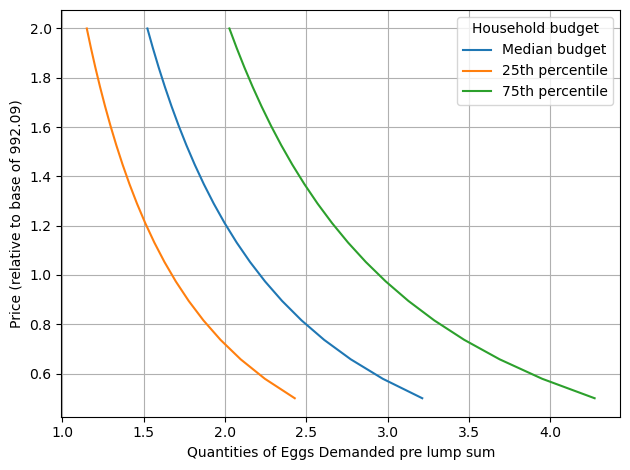

In [293]:
import matplotlib.pyplot as plt

use = 'Eggs'  # CHANGE FOOD TYPE HERE

# Vary prices from 50% to 200% of reference.
scale = np.linspace(.5, 2, 20)

# Demand for household at median budget
plt.plot(
    [result.demands(xref,      my_prices(use, pbar[use]*s, pbar))[use] for s in scale],
    scale,
    label='Median budget'
)

# Demand for household at 25th percentile
plt.plot(
    [result.demands(xbar.quantile(0.25), my_prices(use, pbar[use]*s, pbar))[use] for s in scale],
    scale,
    label='25th percentile'
)

# Demand for household at 75th percentile
plt.plot(
    [result.demands(xbar.quantile(0.75), my_prices(use, pbar[use]*s, pbar))[use] for s in scale],
    scale,
    label='75th percentile'
)

plt.xlabel(f"Quantities of {use} Demanded pre lump sum")
plt.ylabel(f"Price (relative to base of {pbar[use]:.2f})")

plt.grid(True)                          # add grid lines
plt.legend(title='Household budget')   # add legend
plt.tight_layout()
plt.show()


#### Engel Curves - how expenditure shares change with income.

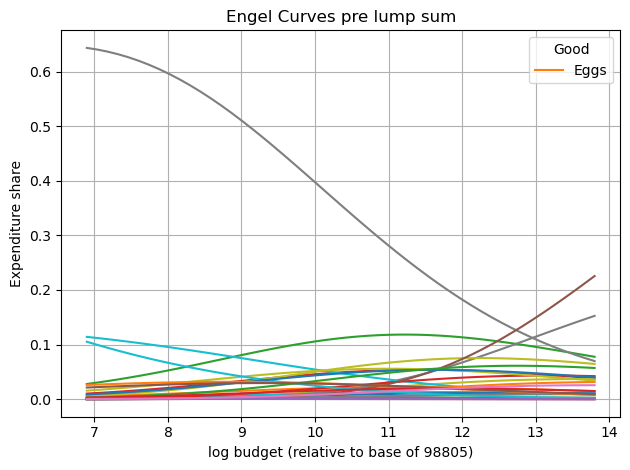

In [294]:
fig, ax = plt.subplots()

scale = np.geomspace(.01, 10, 50)

# compute the Engel shares for each good at each budget scale
y_data = [
    result.expenditures(s * xref, pbar) / (s * xref)
    for s in scale
]

# plot one line per good, capturing all Line2D objects
lines = ax.plot(
    np.log(scale * xref),
    y_data
)

ax.set_xlabel(f'log budget (relative to base of {xref:.0f})')
ax.set_ylabel('Expenditure share')
ax.set_title('Engel Curves pre lump sum')

ax.grid(True)  # add grid lines

# find the position of 'Eggs' in your goods index
goods = list(result.expenditures(xref, pbar).index)
egg_pos = goods.index('Eggs')

# show only the 'Eggs' line in the legend
egg_line = lines[egg_pos]
ax.legend([egg_line], ['Eggs'], title='Good')

fig.tight_layout()
plt.show()


## Engle Curves Pre Lump Sum focus on calcium foods

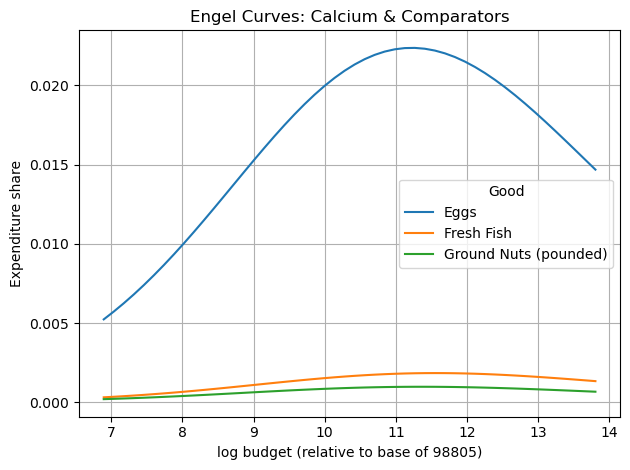

In [295]:
import numpy as np
import matplotlib.pyplot as plt

# 1) choose just the few goods you want to compare
goods_to_show = ['Eggs', 'Fresh Fish', 'Ground Nuts (pounded)']

fig, ax = plt.subplots()
scale = np.geomspace(.01, 10, 50)

for g in goods_to_show:
    # compute expenditure share for good g at each budget scale
    shares = [
        result.expenditures(s * xref, pbar)[g] / (s * xref)
        for s in scale
    ]
    ax.plot(
        np.log(scale * xref),
        shares,
        label=g
    )

ax.set_xlabel(f'log budget (relative to base of {xref:.0f})')
ax.set_ylabel('Expenditure share')
ax.set_title('Engel Curves: Calcium & Comparators')

ax.grid(True)
ax.legend(title='Good')
fig.tight_layout()
plt.show()


## **Lump Sum Calcium**

## Demand & Engle Curves Post Lump Sum

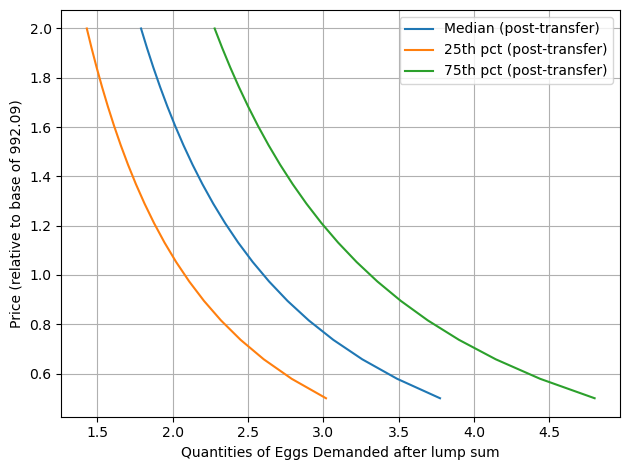

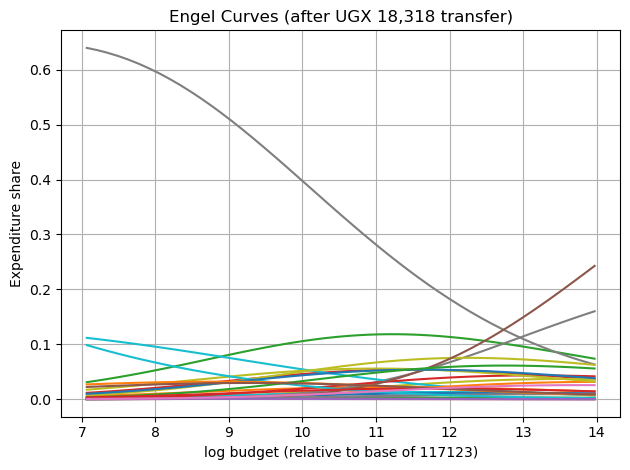

In [296]:
# ─── Reference Prices (unchanged) ─────────────────────────────────────────────

col_prices = p.mean(axis=0)
pbar = col_prices.groupby(level='j').mean()
# Keep only the goods you have betas for, fill missing with 1
pbar = pbar.reindex(result.beta.index).fillna(1)

def my_prices(j, p0, p=pbar):
    """
    Change price of jth good to p0, holding other prices fixed at p.
    """
    p = p.copy()
    p.loc[j] = p0
    return p


# ─── Budgets + Lump-Sum ────────────────────────────────────────────────────────

import numpy as np

# 1) Predicted food expenditures by household (i,t,m,j)
xhat = result.predicted_expenditures()

# 2) Total food budget per household
xbar = xhat.groupby(['i','t','m']).sum()

# 3) Reference (median) household budget
xref = xbar.quantile(0.5)

# 4) Lump-sum transfer you want to simulate
lump = 18318  # 15 USD

# 5) “New” budgets after transfer
xbar_new = xbar + lump
xref_new = xref + lump


# ─── Food Quantities (unchanged) ──────────────────────────────────────────────

qhat = (xhat.unstack('j') / pbar).dropna(how='all')
qhat = qhat.loc[:, qhat.count() > 0]


# ─── Demands with Lump-Sum ─────────────────────────────────────────────────────

import matplotlib.pyplot as plt

use   = 'Eggs'         # change food type here
scale = np.linspace(.5, 2, 20)  # price scales relative to pbar[use]

plt.figure()

# Demand at new median budget
plt.plot(
    [ result.demands(xref_new, my_prices(use, pbar[use]*s))[use] for s in scale ],
    scale,
    label='Median (post-transfer)'
)

# Demand at new 25th percentile budget
q25 = xbar.quantile(0.25) + lump
plt.plot(
    [ result.demands(q25, my_prices(use, pbar[use]*s))[use] for s in scale ],
    scale,
    label='25th pct (post-transfer)'
)

# Demand at new 75th percentile budget
q75 = xbar.quantile(0.75) + lump
plt.plot(
    [ result.demands(q75, my_prices(use, pbar[use]*s))[use] for s in scale ],
    scale,
    label='75th pct (post-transfer)'
)

plt.ylabel(f"Price (relative to base of {pbar[use]:.2f})")
plt.xlabel(f"Quantities of {use} Demanded after lump sum")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# ─── Engel Curves with Lump-Sum ────────────────────────────────────────────────

fig, ax = plt.subplots()
scale = np.geomspace(.01, 10, 50)

# Plot expenditure‐shares at post-transfer budgets
ax.plot(
    np.log(scale * xref_new),
    [
      result.expenditures(s*xref_new, pbar) / (s*xref_new)
      for s in scale
    ]
)

ax.set_xlabel(f'log budget (relative to base of {xref_new:.0f})')
ax.set_ylabel('Expenditure share')
ax.set_title('Engel Curves (after UGX {:,.0f} transfer)'.format(lump))
ax.grid(True)
fig.tight_layout()
plt.show()


## Engle Curves Post Lump Sum focus on calcium foods

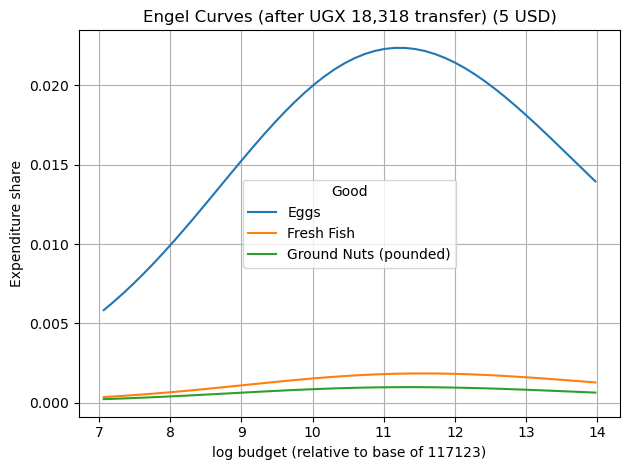

In [318]:
# ─── Engel Curves with Lump-Sum (only selected goods) ───────────────────────────
fig, ax = plt.subplots()
scale = np.geomspace(.01, 10, 50)

goods_to_show = ['Eggs', 'Fresh Fish', 'Ground Nuts (pounded)']
for g in goods_to_show:
    shares = [
        result.expenditures(s * xref_new, pbar)[g] / (s * xref_new)
        for s in scale
    ]
    ax.plot(
        np.log(scale * xref_new),
        shares,
        label=g
    )

ax.set_xlabel(f'log budget (relative to base of {xref_new:.0f})')
ax.set_ylabel('Expenditure share')
ax.set_title('Engel Curves (after UGX {:,.0f} transfer) (5 USD)'.format(lump))
ax.grid(True)
ax.legend(title='Good')
fig.tight_layout()
plt.show()


### Comparison of Engle curves of Eggs before and after the transfer 

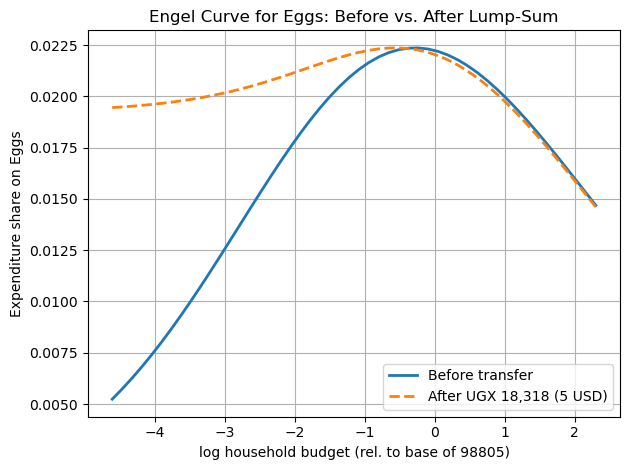

In [319]:
import numpy as np
import matplotlib.pyplot as plt

use  = 'Eggs'
lump = 18318   # your UGX transfer
xref = float(xref) # make sure it’s a scalar

# 1) build a grid of absolute budgets around the original median
budg = np.geomspace(xref * 0.01, xref * 10, 50)

# 2) compute the common x-axis: log(budget/ xref)
ln_rel = np.log(budg / xref)

# 3) compute shares BEFORE and AFTER at **the same** budg points
shares_pre  = [ result.expenditures(b,         pbar)[use] / b       for b in budg ]
shares_post = [ result.expenditures(b + lump,  pbar)[use] / (b+lump) for b in budg ]

# 4) plot them on the same x-axis
fig, ax = plt.subplots()

ax.plot(   ln_rel, shares_pre,  label='Before transfer', linewidth=2)
ax.plot(   ln_rel, shares_post, '--', label=f'After UGX {lump:,.0f} (5 USD)', linewidth=2)

ax.set_xlabel(f'log household budget (rel. to base of {xref:.0f})')
ax.set_ylabel(f'Expenditure share on {use}')
ax.set_title(f'Engel Curve for {use}: Before vs. After Lump‐Sum')
ax.grid(True)
ax.legend()
fig.tight_layout()
plt.show()


## Central Region Pre and Post Engle curves 

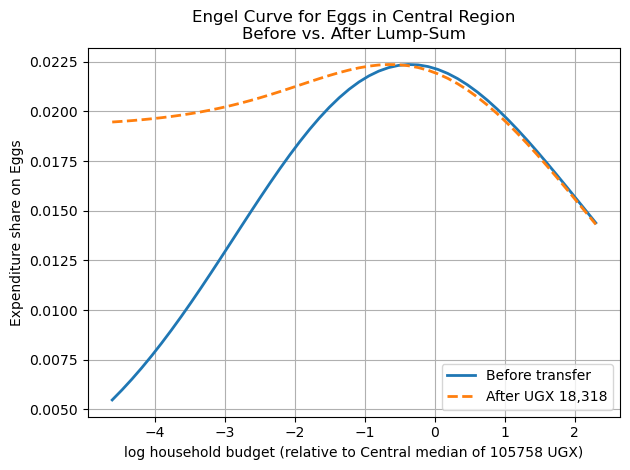

In [321]:
import numpy as np
import matplotlib.pyplot as plt

use  = 'Eggs'
lump = 18318    # UGX transfer (~5 USD)

# 1) get Central region’s household budgets and median
xhat = result.predicted_expenditures()               # (i,t,m,j)
xbar = xhat.groupby(['i','t','m']).sum()             # total UGX per household
central_budgets = xbar.xs('Central', level='m')      # slice to Central region
xref_central   = float(central_budgets.quantile(0.5)) # median UGX per household

# 2) build budget grid around that regional median
budg   = np.geomspace(xref_central * 0.01, xref_central * 10, 50)
ln_rel = np.log(budg / xref_central)

# 3) compute Engel‐shares before & after
shares_pre  = [ result.expenditures(b,        pbar)[use] / b        for b in budg        ]
shares_post = [ result.expenditures(b + lump, pbar)[use] / (b + lump) for b in budg ]

# 4) plot
fig, ax = plt.subplots()
ax.plot(  ln_rel, shares_pre,  label='Before transfer', linewidth=2)
ax.plot(  ln_rel, shares_post, '--', label=f'After UGX {lump:,}', linewidth=2)

ax.set_xlabel(f'log household budget (relative to Central median of {xref_central:.0f} UGX)')
ax.set_ylabel(f'Expenditure share on {use}')
ax.set_title('Engel Curve for Eggs in Central Region\nBefore vs. After Lump-Sum')
ax.grid(True)
ax.legend()
fig.tight_layout()
plt.show()


# Regional Differences in Egg Expenditure before and after the lump sum


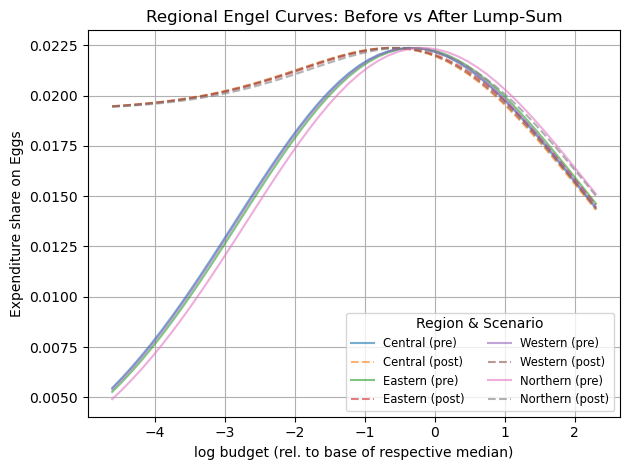

In [300]:
import numpy as np
import matplotlib.pyplot as plt

use  = 'Eggs'
lump = 18318   # cash transfer

# 1) get the list of regions
regions = xbar.index.get_level_values('m').unique()

fig, ax = plt.subplots()
for reg in regions:
    # 2) slice to that region's households
    budgets_reg = xbar.xs(reg, level='m')

    # 3) region‐specific median and grid
    xref_reg = budgets_reg.quantile(0.5)
    budg = np.geomspace(xref_reg*0.01, xref_reg*10, 50)
    ln_rel = np.log(budg / xref_reg)

    # 4) compute shares before & after
    shares_pre  = [ result.expenditures(b,       pbar)[use]/b       for b in budg ]
    shares_post = [ result.expenditures(b+lump,  pbar)[use]/(b+lump) for b in budg ]

    # 5) plot them
    ax.plot(ln_rel, shares_pre,  label=f'{reg} (pre)',  alpha=0.6)
    ax.plot(ln_rel, shares_post,'--', label=f'{reg} (post)', alpha=0.6)

# annotate
ax.set_xlabel(f'log budget (rel. to base of respective median)')
ax.set_ylabel(f'Expenditure share on {use}')
ax.set_title('Regional Engel Curves: Before vs After Lump‐Sum')
ax.grid(True)
ax.legend(ncol=2, fontsize='small', title='Region & Scenario')
fig.tight_layout()
plt.show()


# Nurtritional adequacy 

In [301]:
columns_to_average = [col for col in d.columns if col.startswith('Females') or col.startswith('Males')]

dbar = d[columns_to_average].mean()

In [302]:
rdi_renamed = rdi.copy()
rdi_renamed.columns = rdi_renamed.columns.to_series() \
    .str.replace('^F ', 'Females ', regex=True) \
    .str.replace('^M ', 'Males ', regex=True) \
    .str.replace('51\\+', '51-99', regex=True)

# Reorder columns to match dbar index
rdi_aligned = rdi_renamed[dbar.index]

# Matrix multiply
hh_rdi = rdi_aligned @ dbar   # example: for 7 days
hh_rdi

n
Energy          10179.623403
Protein           223.121385
Fiber             142.514728
Folate           1884.431742
Calcium          6265.332885
Carbohydrate      765.924681
Iron               62.606254
Magnesium        1602.030935
Niacin             72.034970
Phosphorus       4754.031607
Potassium       25390.080699
Riboflavin          5.636785
Thiamin             5.481473
Vitamin A        3757.061197
Vitamin B-12       11.306590
Vitamin B-6         6.200605
Vitamin C         333.589442
Vitamin E          70.216543
Vitamin K         444.909213
Zinc               45.674849
dtype: float64

In [303]:
def nutrient_adequacy_ratio(x, p, d, rdi = rdi_aligned, days=7):
    # 1) copy & rename RDI columns so they line up with d.index
    rdi_clean = rdi.copy()
    rdi_clean.columns = (
        rdi_clean.columns
        .to_series()
        .str.replace('F ', 'Females ', regex=False)
        .str.replace('M ', 'Males ',   regex=False)
    )
    rdi_clean.columns = rdi_clean.columns.str.replace('51\\+', '51–99', regex=True)

    # 2) replace any blank entries with zero
    rdi_clean = rdi_clean.replace('', 0)

    # 3) re-order (and fill) so that columns == d.index
    #    any missing columns become zeros
    rdi_aligned = rdi_clean.reindex(columns=d.index, fill_value=0)

    # 4) compute household RDI and divide demand by it
    hh_rdi = (rdi_aligned @ d) * days
    return nutrient_demand(x, p) / hh_rdi


In [304]:
def nutrient_demand(x,p):
    c = result.demands(x,p)
    fct0,c0 = fct.align(c,axis=0,join='inner')
    N = fct0.T@c0

    N = N.loc[~N.index.duplicated()]
    
    return N

In [305]:
z = z[rdi.columns.tolist()]

hh_rdi = z@rdi.T

# Uganda data is per week, so make this a recommended WEEKLY intake:
hh_rwi = hh_rdi*7

In [306]:
# Match up nutrient names
use_nutrients = nutrients.columns.intersection(hh_rwi.columns)

nutrient_ratio = (nutrients[use_nutrients]/hh_rwi[use_nutrients]).dropna()

nutrient_ratio

,,n,Energy,Protein,Fiber,Folate,Calcium,Carbohydrate,Iron,Niacin,Riboflavin,Thiamin,Vitamin A,Vitamin B-12,Vitamin B-6,Vitamin C,Zinc
i,t,m,,,,,,,,,,,,,,,
1013000201,2009-10,Central,1.304579,1.305324,1.662995,1.413507,0.636470,3.051617,1.301633,1.258837,1.659641,1.485592,0.619186,1.045713,3.196247,3.892626,1.168947
1013000204,2009-10,Central,1.432731,1.402462,1.834457,1.617108,0.621144,2.745308,1.497059,1.410572,1.694947,1.654486,0.677010,0.959754,3.828059,5.206486,1.237307
1013000206,2009-10,Central,4.349414,3.992361,5.360252,5.559280,3.128777,11.391227,9.077256,3.968566,6.103066,4.652432,2.629498,4.723953,11.052171,13.118085,3.396578
101300021302,2009-10,Central,1.714505,1.807785,2.071020,1.985358,0.934065,3.752361,1.999078,1.653456,2.407922,1.987030,0.921584,1.800073,4.280382,4.820115,1.570257
1021000102,2009-10,Central,1.393774,1.216820,1.707928,1.382136,0.651453,2.957056,1.332623,1.246534,1.623217,1.387065,0.650759,1.115215,3.054229,3.824844,1.130714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4193003504,2009-10,Western,0.943162,1.018301,1.247723,0.989965,0.361370,2.752456,1.435597,1.024105,1.050548,1.441941,0.335738,0.559128,2.716331,3.830943,0.845285
4193003506,2009-10,Western,0.891553,0.815000,1.316845,1.017605,0.382406,2.463398,1.224327,0.951153,1.053496,1.229850,0.371422,0.674222,2.799961,3.880978,0.742845
4193003507,2009-10,Western,2.381779,2.202646,3.542939,2.487706,0.981543,6.947162,3.824408,2.413610,2.850746,3.119212,1.161288,1.467598,6.148788,9.787539,1.876018


## Focus on 1 region 

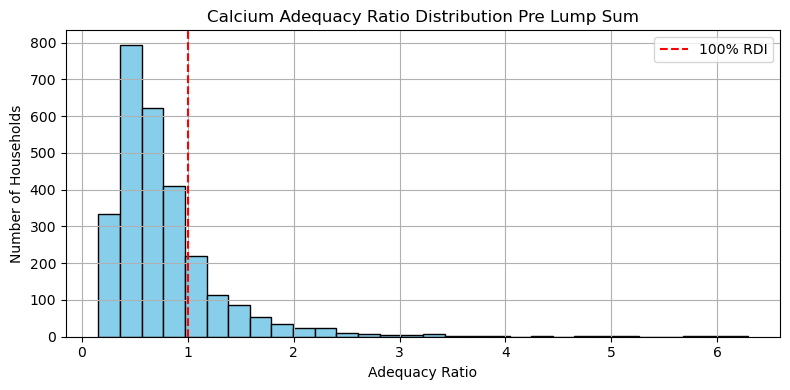

In [307]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
nutrient_ratio['Calcium'].hist(
    bins=30,
    color='skyblue',
    edgecolor='black'
)
plt.axvline(1, color='red', linestyle='--', label='100% RDI')
plt.title('Calcium Adequacy Ratio Distribution Pre Lump Sum')
plt.xlabel('Adequacy Ratio')
plt.ylabel('Number of Households')
plt.legend()
plt.tight_layout()
plt.show()


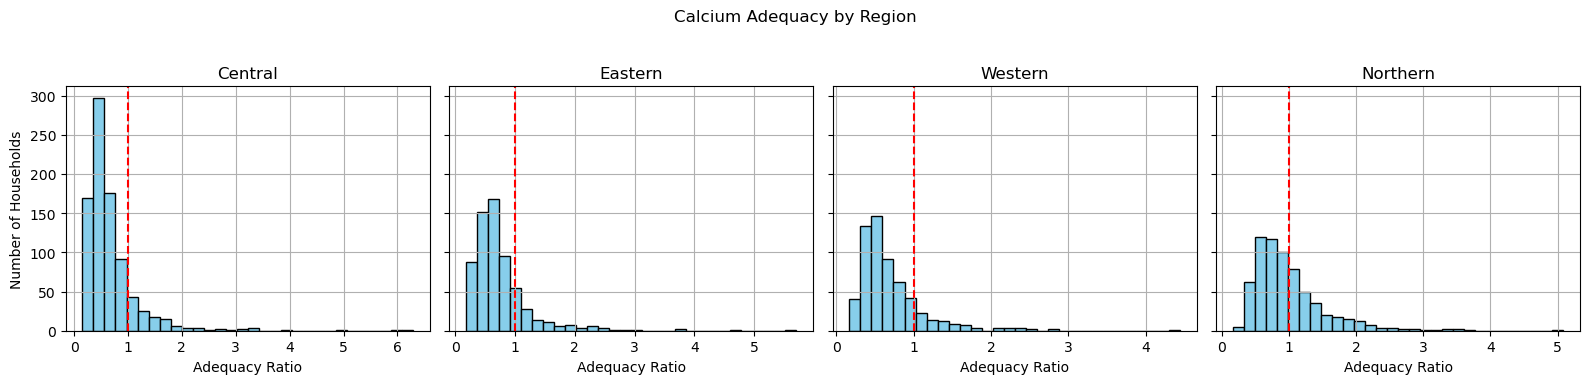

In [308]:
import matplotlib.pyplot as plt

# get the list of regions
regions = nutrient_ratio.index.get_level_values('m').unique().tolist()

# make one histogram per region, side by side
fig, axes = plt.subplots(
    nrows=1, 
    ncols=len(regions), 
    figsize=(4*len(regions), 4), 
    sharey=True
)

for ax, region in zip(axes, regions):
    # slice out just that region
    ca = nutrient_ratio.xs(region, level='m')['Calcium']
    
    # plot
    ca.hist(
        ax=ax, 
        bins=30, 
        color='skyblue', 
        edgecolor='black'
    )
    ax.axvline(1, color='red', linestyle='--')
    ax.set_title(region)
    ax.set_xlabel('Adequacy Ratio')
    if ax is axes[0]:
        ax.set_ylabel('Number of Households')

plt.suptitle('Calcium Adequacy by Region')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [309]:
import pandas as pd

# 1) Total household budgets
xhat = result.predicted_expenditures()             
xbar = xhat.groupby(['i','t','m']).sum()           

# 2) Per-person budgets
avg_hh_size = dbar.sum()                           
xpp = xbar / avg_hh_size                           

# 3) Median per-person budget by region
xref_pp = xpp.groupby(level='m').quantile(0.5)      

# 4) Compute median calcium adequacy at those medians
region_ca_pre = pd.Series({
    region: nutrient_adequacy_ratio(xref_pp[region], pbar, dbar, rdi)['Calcium']
    for region in xref_pp.index
}).sort_values()

# 5) Print the list
print("Median Calcium adequacy by region (pre-lump-sum), lowest first:")
for region, ca in region_ca_pre.items():
    print(f"{region}: {ca:.2f}×RDI")


Median Calcium adequacy by region (pre-lump-sum), lowest first:
Northern: 1.50×RDI
Eastern: 1.75×RDI
Western: 1.84×RDI
Central: 1.89×RDI


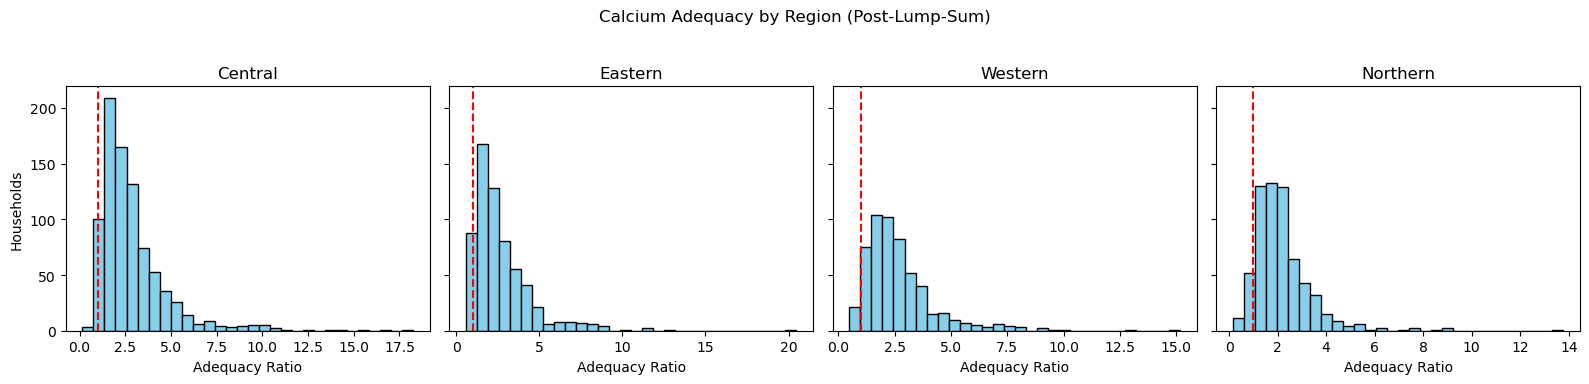

In [310]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1) Recompute per‐person budgets
avg_hh_size = dbar.sum()
xhat = result.predicted_expenditures()             
xbar = xhat.groupby(['i','t','m']).sum()           
xpp = xbar / avg_hh_size                          

# 2) Define lump‐sum in per‐person terms
lump = 18318          # UGX per household
lump_pp = lump / avg_hh_size

# 3) Build a Series of post–transfer Calcium adequacy per household
xpp_post = xpp + lump_pp
post_ca = pd.Series(
    [nutrient_adequacy_ratio(x, pbar, dbar, rdi)['Calcium'] for x in xpp_post],
    index=xpp_post.index
)

# 4) Plot one histogram per region
regions = post_ca.index.get_level_values('m').unique().tolist()
fig, axes = plt.subplots(
    nrows=1, 
    ncols=len(regions), 
    figsize=(4*len(regions), 4), 
    sharey=True
)

for ax, region in zip(axes, regions):
    data = post_ca.xs(region, level='m')
    ax.hist(data, bins=30, color='skyblue', edgecolor='black')
    ax.axvline(1, color='red', linestyle='--')
    ax.set_title(region)
    ax.set_xlabel('Adequacy Ratio')
    if ax is axes[0]:
        ax.set_ylabel('Households')

plt.suptitle('Calcium Adequacy by Region (Post‐Lump‐Sum)')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


## Central Region Calcium Pre Lump

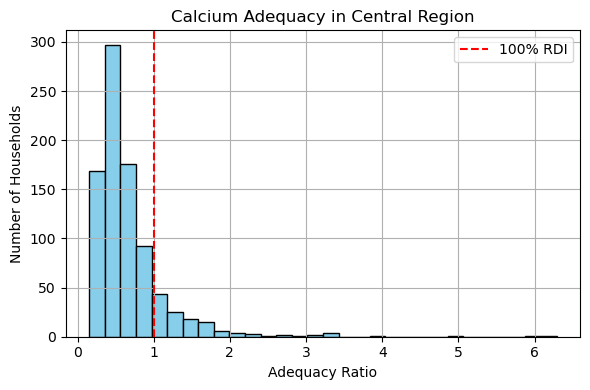

In [311]:
import matplotlib.pyplot as plt

# select just the Central region
region = 'Central'
ca = nutrient_ratio.xs(region, level='m')['Calcium']

# single histogram
plt.figure(figsize=(6, 4))
ca.hist(
    bins=30,
    color='skyblue',
    edgecolor='black'
)
plt.axvline(1, color='red', linestyle='--', label='100% RDI')
plt.title(f'Calcium Adequacy in {region} Region')
plt.xlabel('Adequacy Ratio')
plt.ylabel('Number of Households')
plt.legend()
plt.tight_layout()
plt.show()


## Central Region Calcium Post Lump

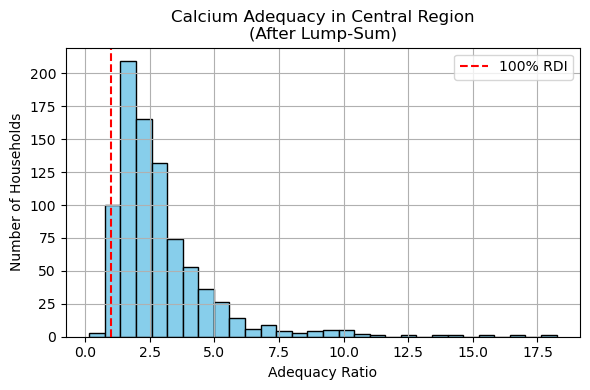

In [312]:
import matplotlib.pyplot as plt

# --- Assuming you’ve already built the post‐transfer Series `post_ca` ---
# post_ca = pd.Series(
#     [nutrient_adequacy_ratio(x + lump_pp, pbar, dbar, rdi)['Calcium'] for x in xpp],
#     index=xpp.index
# )

# 1) slice out Central region
ca_central_post = post_ca.xs('Central', level='m')

# 2) plot histogram
plt.figure(figsize=(6, 4))
ca_central_post.hist(
    bins=30,
    color='skyblue',
    edgecolor='black'
)
plt.axvline(1, color='red', linestyle='--', label='100% RDI')
plt.title('Calcium Adequacy in Central Region\n(After Lump‐Sum)')
plt.xlabel('Adequacy Ratio')
plt.ylabel('Number of Households')
plt.legend()
plt.tight_layout()
plt.show()
